### Correlation Function
Import Package 

i)   numpy   
ii)  deepdish (to read HDF5)   
iii) Plot (personal package, that load my personal RC)   
iv)  math (since log10 is faster for math than for numpy, at least for single cases in my pc)   

In [1]:
import numpy as np
import deepdish as dd
import Plot
import math as m
Plot.Load_RC()

%load_ext Cython
%matplotlib inline 

### Read the simulation
Read DeLucia+07 SAM, run over the millimil, a 62.5 Mpc/h dark matter simulation with Millennium cosmology

In [2]:
d = dd.io.load('DeLucia.hdf5')
pos = d['pos']

Reduce the number of objects for a faster example

In [3]:
index = np.arange(len(pos))
index = np.random.choice(index, size=5000, replace=False)
pos = pos[index]

In [4]:
Lbox = 62.5

In [5]:
xmin, xmax, Nbins = -2.0, 1.0, 30
dlogr = (xmax-xmin)/float(Nbins)
logr = np.linspace(xmin, xmax, Nbins,endpoint=False)+dlogr/2


Load de DR

In [6]:
def DR(NBin = 30,Xmin = -2,Xmax = 1,Lbox = 62.5,Ng=100):
    dr = []
    for i in range(NBin):
        Min = 10**(Xmin+i/float(NBin)*(Xmax-Xmin))
        Max = 10**(Xmin+(i+1)/float(NBin)*(Xmax-Xmin))
        Vol = 4./3.*3.1415926*((Max**3)-(Min**3))
        Den = Ng*Lbox**(-3)
        dr.append(Vol*Den*Ng)
    return np.array(dr)

### Python Code
The python code of the DD term, we only calculate halph of the pairs (so xi = 2*DD/DR-1)   

In [7]:
%%time
def DD_python(pos,Nbins = 30,xmin = -2,xmax = 1,Lbox = 62.5):
    DD = np.zeros(Nbins)
    Ng = len(pos)
    for i in range(Ng):
        for j in range(i+1, Ng):
            dx = abs(pos[i][0]-pos[j][0])
            dy = abs(pos[i][1]-pos[j][1]) 
            dz = abs(pos[i][2]-pos[j][2])
            
            if (dx > 0.5*Lbox): dx = Lbox - dx
            if (dy > 0.5*Lbox): dy = Lbox - dy
            if (dz > 0.5*Lbox): dz = Lbox - dz

            dlogdist = 0.5 * m.log10(dx*dx + dy*dy + dz*dz+1e-10)
            index = int((dlogdist - xmin) / dlogr)
            if(index >= 0 and index < Nbins): DD[index] += 1
    return DD
DD_p = DD_python(pos,Nbins,xmin,Lbox)
Xi_p = 2*DD_p/DR(Nbins,xmin,xmax,Lbox,len(pos))-1

CPU times: user 28 s, sys: 192 ms, total: 28.2 s
Wall time: 27.8 s


### Cython Code
All variables (input and internal) are initialized.   
It is possible to import c functions from math.h.    
This is comments since it will crush if this is not properly install in your computer
Using math.h function will improve the performance of the code compare to normal numpy or math functions   
It return a np.array, if only 'DD' is return, python will be not able to 'understand' the output.

In [8]:
%%cython
import numpy as np
import math as m
#cdef extern from "<math.h>":
#        double log10(double x)
def DD_cython(double[:, :] pos,int Nbins = 30, float xmin = -2, float xmax = 1,float Lbox = 62.5):   
    cdef double dlogr = (xmax-xmin)/Nbins
    cdef long[:] DD = np.zeros(Nbins, dtype=int)
    
    cdef double dx, dy, dz, dlogdist
    cdef int i, j, index
    
    for i in range(len(pos)):
        for j in range(i+1, len(pos)):
            dx = abs(pos[i][0]-pos[j][0])
            dy = abs(pos[i][1]-pos[j][1]) 
            dz = abs(pos[i][2]-pos[j][2])
            
            if (dx > 0.5*Lbox): dx = Lbox - dx
            if (dy > 0.5*Lbox): dy = Lbox - dy
            if (dz > 0.5*Lbox): dz = Lbox - dz
            #dlogdist = 0.5 * log10(dx*dx + dy*dy + dz*dz+1e-10)
            dlogdist = 0.5 * m.log10(dx*dx + dy*dy + dz*dz+1e-10)
            index = int((dlogdist - xmin) / dlogr)
            if(index >= 0 and index < Nbins): DD[index] += 1
    return np.array(DD)

In [9]:
%%time
DD_c = DD_cython(pos,Nbins,xmin,Lbox)
Xi_c = 2*DD_p/DR(Nbins,xmin,xmax,Lbox,len(pos))-1

CPU times: user 2.59 s, sys: 0 ns, total: 2.59 s
Wall time: 2.59 s


It is possible to add some compilation option than can improve even more the speed of the code.   
For more information go to http://cython.readthedocs.io/en/latest/src/reference/compilation.html

In [10]:
%%cython
import numpy as np
import math as m
cimport cython 

@cython.boundscheck(False)  # Assume indexing operations will not cause any IndexErrors to be raised
@cython.wraparound(False)  #  Accessing array elements with negative numbers is not permissible
@cython.nonecheck(False)  #  Never waste time checking whether a variable has been set to None

def DD_cython(double[:, :] pos,int Nbins = 30, float xmin = -2, float xmax = 1,float Lbox = 62.5):   
    cdef double dlogr = (xmax-xmin)/Nbins
    cdef long[:] DD = np.zeros(Nbins, dtype=int)
    #cdef extern from "<math.h>":
    #    double log10(double x)
    cdef double dx, dy, dz, dlogdist
    cdef int i, j, index
    
    for i in range(len(pos)):
        for j in range(i+1, len(pos)):
            dx = abs(pos[i][0]-pos[j][0])
            dy = abs(pos[i][1]-pos[j][1]) 
            dz = abs(pos[i][2]-pos[j][2])
            
            if (dx > 0.5*Lbox): dx = Lbox - dx
            if (dy > 0.5*Lbox): dy = Lbox - dy
            if (dz > 0.5*Lbox): dz = Lbox - dz
            #dlogdist = 0.5 * log10(dx*dx + dy*dy + dz*dz+1e-10)
            dlogdist = 0.5 * m.log10(dx*dx + dy*dy + dz*dz+1e-10)
            index = int((dlogdist - xmin) / dlogr)
            if(index >= 0 and index < Nbins): DD[index] += 1
    return np.array(DD)

In [11]:
%%time
DD_c = DD_cython(pos,Nbins,xmin,Lbox)
Xi_c = 2*DD_p/DR(Nbins,xmin,xmax,Lbox,len(pos))-1

CPU times: user 2.39 s, sys: 0 ns, total: 2.39 s
Wall time: 2.4 s


### Testing the results
There should be a perfect agreement between the methos

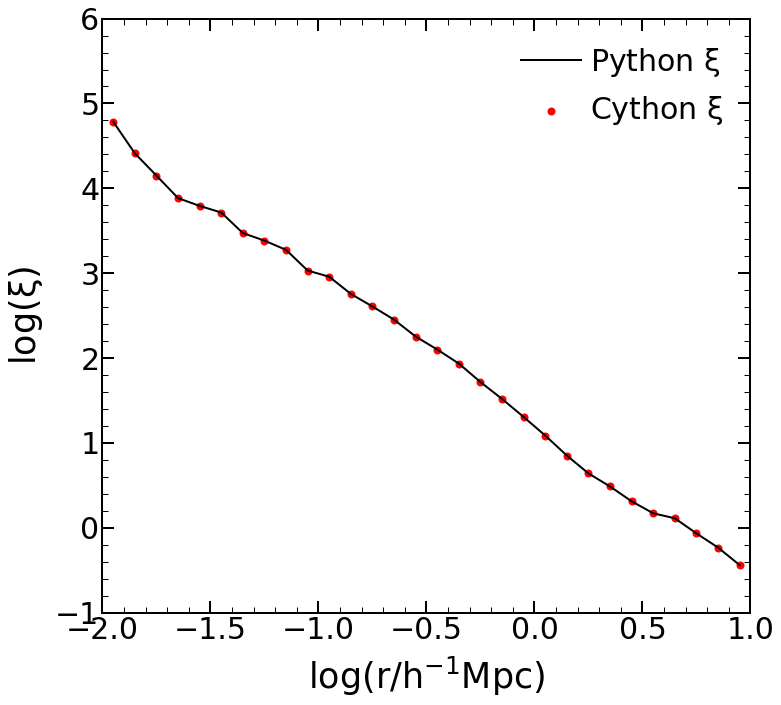

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot():    
    fig,ax0 = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    gs = gridspec.GridSpec(1, 1)
    gs.update(hspace=0.0)
    ax = plt.subplot(gs[0,0])

    ax.plot(logr     ,np.log10(Xi_p),color =  'k', ls='-', linewidth=2, label=r'$\rm Python\ \xi$')  
    ax.scatter(logr     ,np.log10(Xi_c),c =  'r', linewidth=2, label=r'$\rm Cython\ \xi$')  
    #ax.plot(logr[:-1],np.log10(Xi_h),color =  'b', ls=':', linewidth=2, label=r'$\rm Halotools\ \xi$')        
    ax.legend(loc='upper right', shadow=True,fontsize=30,frameon=False) 
    ####################################################################################################
    ax.set_xlim([-2, 1])
    ax.set_ylim([-1, 6])
    ####################################################################################################
    ax.set_xlabel(r'$\rm log(r/h^{-1}Mpc)$', fontsize=35)
    ax.set_ylabel(r'$\rm log(\xi)$', fontsize=35)
plot()


A comparison with HaloTools shows only 1 point of desagreement...

In [13]:
import halotools.mock_observables as htools
Xi_h = htools.tpcf(pos, 10**(logr-dlogr/2), period=Lbox)

/home/sergio/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


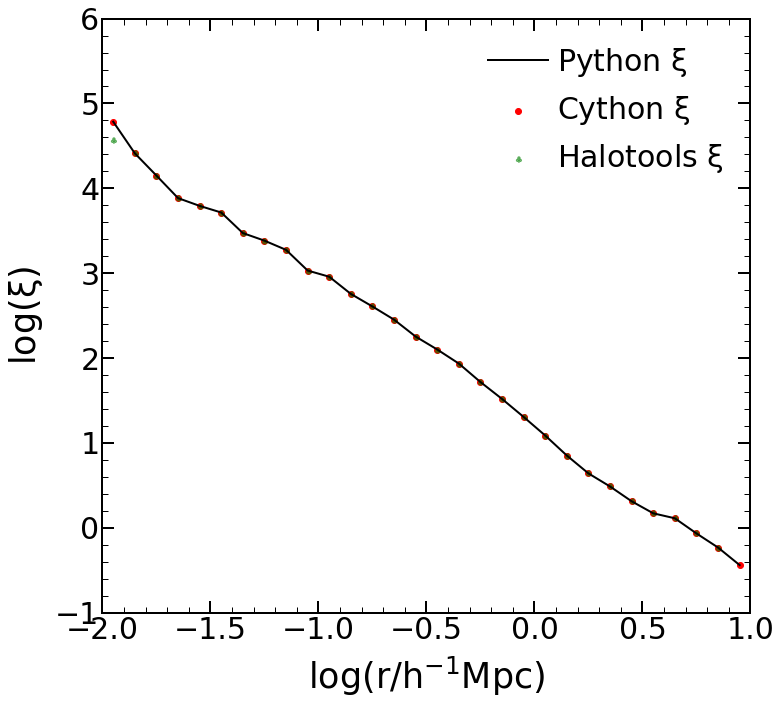

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot():    
    fig,ax0 = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    gs = gridspec.GridSpec(1, 1)
    gs.update(hspace=0.0)
    ax = plt.subplot(gs[0,0])

    ax.plot(logr     ,np.log10(Xi_p),color =  'k', ls='-', linewidth=2, label=r'$\rm Python\ \xi$')  
    ax.scatter(logr     ,np.log10(Xi_c),c =  'r',label=r'$\rm Cython\ \xi$')  
    ax.scatter(logr[:-1],np.log10(Xi_h), c="g", alpha=0.5, marker=r'$\clubsuit$' ,label=r'$\rm Halotools\ \xi$')        
    ax.legend(loc='upper right', shadow=True,fontsize=30,frameon=False) 
    ####################################################################################################
    ax.set_xlim([-2, 1])
    ax.set_ylim([-1, 6])
    ####################################################################################################
    ax.set_xlabel(r'$\rm log(r/h^{-1}Mpc)$', fontsize=35)
    ax.set_ylabel(r'$\rm log(\xi)$', fontsize=35)
plot()
